Classifier performances
--------------------------------------------------------------------------------------------------------------------------------

In [1]:
#Import modules
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import shuffle
from scipy import interp
import statistics as st
import neurolab as nl
import math
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal

In [23]:
def prepare_subplot(i, j, height, width):
    """Set subplot framework"""
    f, axarr = plt.subplots(i,j)
    f.set_figheight(height)
    f.set_figwidth(width)
    return f, axarr

In [3]:
def roc_function(y_score, y_test, k, axarr):
    """Compute roc curves and prepare plot"""
# Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_score.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
        ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plot_places = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2),(3,0),(3,1),(3,2)]
    axarr[plot_places[k]].plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             linewidth=2)

    axarr[plot_places[k]].plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             linewidth=2)

    for i in range(n_classes):
        axarr[plot_places[k]].plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
                                       ''.format(i + 1, roc_auc[i]))

    axarr[plot_places[k]].plot([0, 1], [0, 1], 'k--')
    axarr[plot_places[k]].set_xlim([0.0, 1.0])
    axarr[plot_places[k]].set_ylim([0.0, 1.05])
    
    if plot_places[k][0] == 3:
        axarr[plot_places[k]].set_xlabel('False Positive Rate')
    if plot_places[k][1] == 0:
        axarr[plot_places[k]].set_ylabel('True Positive Rate')
        
    axarr[plot_places[k]].set_title('Subject {0}'.format(k + 1))
    axarr[plot_places[k]].legend(loc='lower right', fontsize = 'x-small')
    
    return

In [56]:
#Get data of all subjects and put it in lists
subjects = range(1,13)
feattr_all = []
labels_all = []
for subject in subjects:
    #Load data
    filename = "train_filtered/filtered_"+str(subject)+".npz"
    datas = np.load(filename)
    feattr = datas['arr_0']
    labels = datas['arr_1']
    
    #Reshape data
    feattr = np.transpose(feattr)
    labels = np.transpose(labels)
    feattr_all.append(feattr)
    labels_all.append(labels)
    n_classes = labels.shape[1]     

In [5]:
def sort_points_sep(feattr, labels):
    """Sort events according to their class"""
    newf= []
    for k in range(labels.shape[1] + 1):
        newf.append([])
    cur_class = labels[0]
    cur_acc = [feattr[0]]
    for k in range(1, len(feattr)):
        lab = labels[k]
        if np.array_equal(lab, cur_class):
            cur_acc = np.concatenate((cur_acc, [feattr[k]]), axis=0)
        else:
            cur_class = lab
            if 1. in lab:
                newf[np.where(lab == 1.)[0][0] + 1].append(cur_acc)
            else:
                newf[0].append(np.array(cur_acc))
            cur_acc = [feattr[k]]
    return np.array(newf)

In [6]:
def plot_feat(sorted_sep):
    """Plot event examples according to their class"""
    f, axarr = prepare_subplot(7, 1, 24, 16)
    for k in range(7):
        for i in range(4):
            acc = sorted_sep[k][0][:,i]
            for j in range(11, 20):
                if i == 0:
                    axarr[k].axvline(float((len(acc)-1))/float(500), c='k', ls='dashed')
                acc = np.concatenate((acc, sorted_sep[k][j][:,i]), axis=0)
            tmax = float((len(acc)-1))/float(500)
            t = np.linspace(0, tmax, len(acc))
            axarr[k].plot(t, acc)
        if k == 6:
            axarr[k].set_xlabel('Time (s)')
        axarr[k].set_xlim([0, tmax])
        axarr[k].set_ylim([-16, -8])
        axarr[k].set_title('Class ' + str(k))
    return f, axarr

In [52]:
###################################### Sort events according to their class #####################################################
sorted_sep = sort_points_sep(feattr_all[0], labels_all[0])

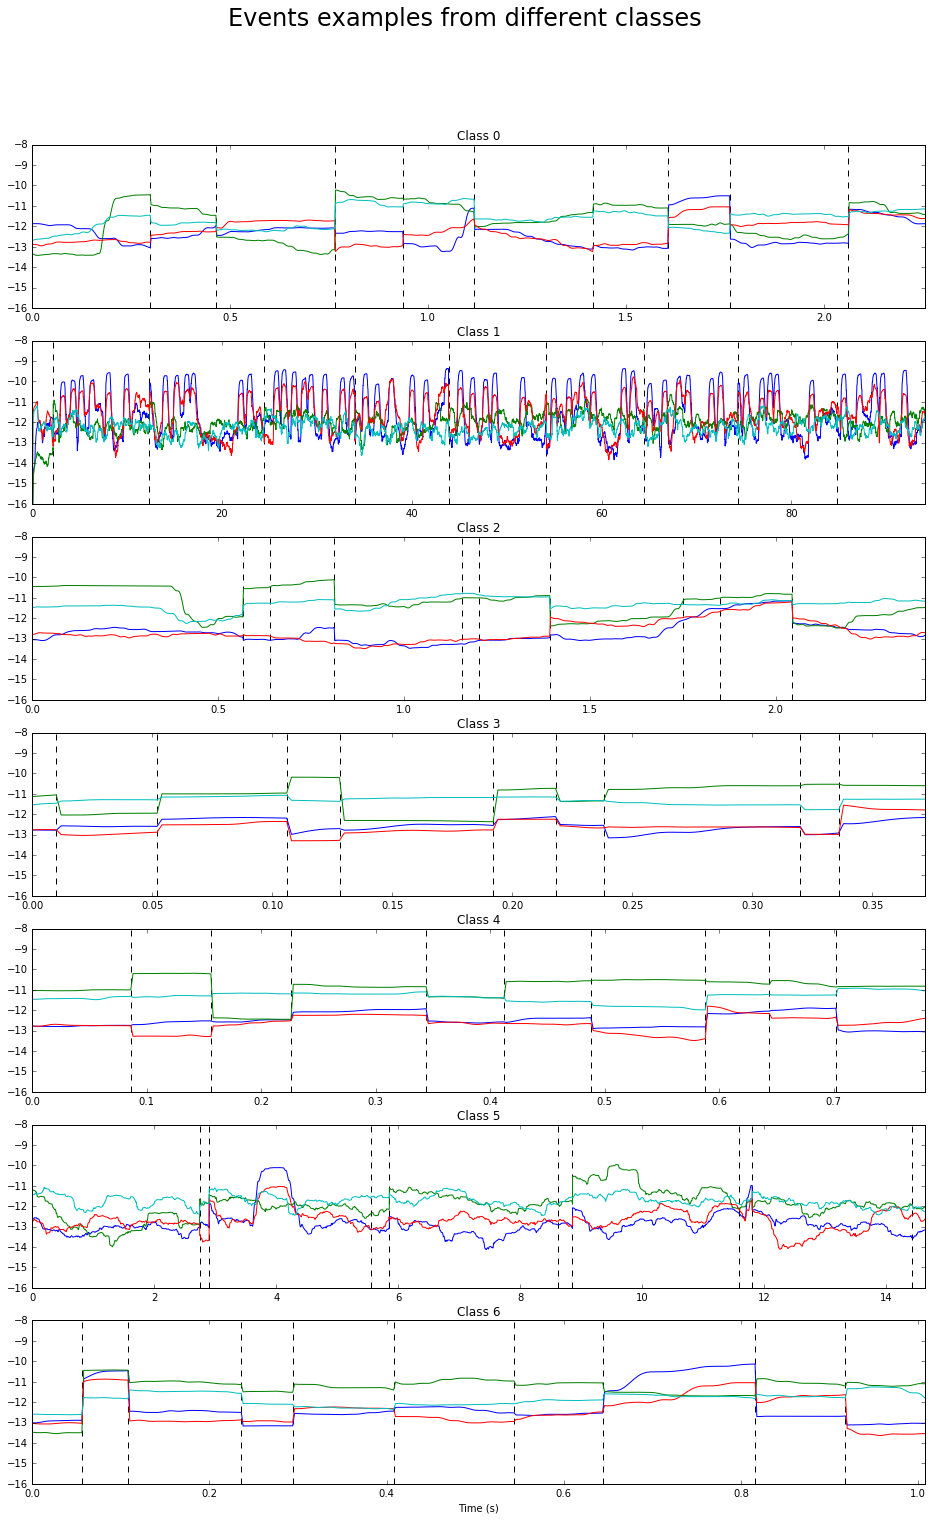

In [53]:
%matplotlib inline
############################## Plot sample examples of different classes ########################################################
f, axarr = plot_feat(sorted_sep)
f.suptitle('Events examples from different classes', fontsize=24)
plt.show()

This figure shows different event examples from all the different classes. The dashed lines delimit the events and one color represents one channel.

First of all, the events have different length, even among the same class. So if we want to use a sequence of samples as unput for our classifier, we need to resize the events so they have all the same length.

Secondly, class 1 has a higher variance than the other classes, thanks to the CSP applied before.

In [46]:
def sort_points(feattr, labels):
    """Sort samples according to their class"""
    new= []
    for n in range(labels.shape[1] + 1):
        new.append([])
    for k in range(len(feattr)):
        lab = labels[k]
        if 1. in lab:
            new[np.where(lab == 1.)[0][0] + 1].append(feattr[k])
        else:
            new[0].append(feattr[k])
    for n in range(labels.shape[1] + 1):
        new[n] = np.array(new[n])
    return new

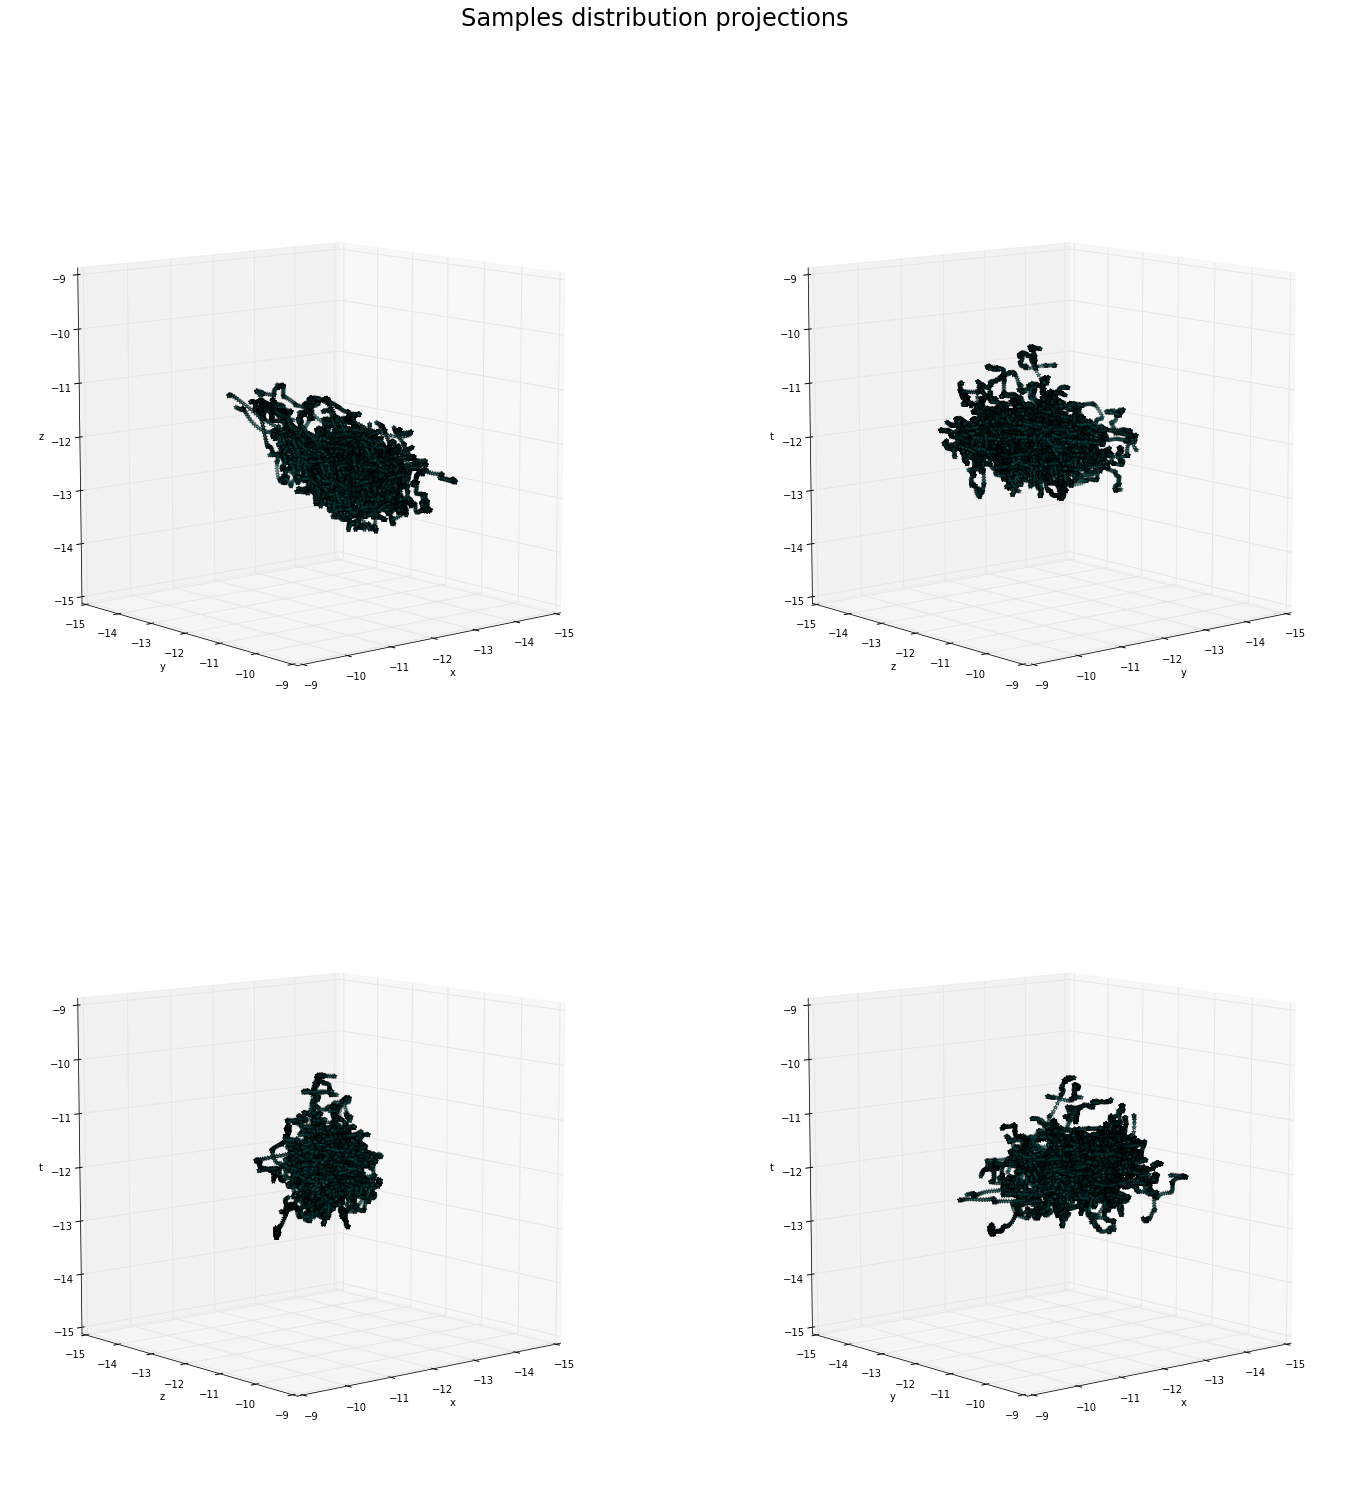

In [50]:
%matplotlib inline
######################################### Display sample distribution ##########################################################
feattr = feattr_all[0]
labels = labels_all[0]
sorted_feat = sort_points(feattr, labels)
fig = plt.figure()
fig.set_figheight(24)
fig.set_figwidth(24)

colors = 'wbrgmcy'
markers = 'ov^<>*s'
labs_fs = ['xyz', 'yzt', 'xzt', 'xyt']
combs = [[0,1,2],[1,2,3],[0,2,3],[0,1,3]]
for c in range(len(combs)):
    for k in range(len(sorted_feat)-1):
        f = sorted_feat[k]
        ax = fig.add_subplot(2,2,c+1, projection='3d')
        ax.scatter(f[:,combs[c][0]], f[:,combs[c][1]], f[:,combs[c][2]], c=colors[k], marker=markers[k])
        ax.set_xlim([-15, -9])
        ax.set_xlabel(labs_fs[c][0])
        ax.set_ylim([-15, -9])
        ax.set_ylabel(labs_fs[c][1])
        ax.set_zlim([-15, -9])
        ax.set_zlabel(labs_fs[c][2])
        ax.view_init(elev=10, azim=50)
fig.suptitle('Samples distribution projections', fontsize=24)
plt.show()

This figure shows projections of the 4 channel sample distribution in 3D. Each class has a different color.

We can see that all the classes are well mixed up.

What we can conclude from this figure is that if we consider only one sample it's very difficult to distinguish the classes. That's why we need to take a sequence of samples and not only one sample as input for our classifier.

In [7]:
def windowed_data(feattr, labels):
    """Sort events according to their class and resize then so they have all the same length (average length) using cut 
    or repeat scheme"""
    nb_classes = labels.shape[1]
    nb_chan = feattr.shape[1]
    newf = sort_points_sep(feattr, labels)
    newl = []
    mean_len = int(np.mean([np.mean([len(f) for f in fs]) for fs in newf]))
    for k in range(len(newf)):
        for j in range(len(newf[k])):
            l = np.zeros((nb_classes))
            if k != 0:
                l[k - 1] = 1.
            newl.append(l)
            if len(newf[k][j]) > mean_len:
                newf[k][j] = newf[k][j][:mean_len]
            elif len(newf[k][j]) < mean_len:
                q = mean_len//len(newf[k][j])
                r = mean_len%len(newf[k][j])

                newf[k][j] = np.tile(newf[k][j], (q,1))
                if r != 0:
                    newf[k][j] = np.concatenate((newf[k][j], np.array(newf[k][j][:r])), axis = 0)
                
    return np.array(newf), np.array(newl)

In [8]:
def resample_data(feattr, labels, beta):
    """Sort events according to their class and resize them so they have all the same length (average length) using resample 
    scheme"""
    nb_classes = labels.shape[1]
    nb_chan = feattr.shape[1]
    newf = sort_points_sep(feattr, labels)
    newl = []
    mean_len = int(np.mean([np.mean([len(f) for f in fs]) for fs in newf]))
    for k in range(len(newf)):
        for j in range(len(newf[k])):
            l = np.zeros((nb_classes))
            if k != 0:
                l[k - 1] = 1.
            newl.append(l)
            if len(newf[k][j]) != mean_len:
                newf[k][j] = signal.resample(newf[k][j], mean_len, window=signal.get_window(('kaiser', beta), len(newf[k][j])))
    return np.array(newf), np.array(newl)

In [9]:
def mix_all(feattr, labels, rnd_state):
    """Mix events from all classes"""
    newfconc = feattr[0]
    for k in range(1, len(feattr)):
        newfconc = np.concatenate((np.array(newfconc), np.array(feattr[k])), axis = 0)

    newf, newl = shuffle(newfconc, labels, random_state = rnd_state)
    return newf, newl

In [13]:
######################################## Cut/repeat data so that they all have the same length ##################################
for k in subjects:
    feattr = feattr_all[k-1]
    labels = labels_all[k-1]
    feattr, labels = windowed_data(feattr, labels)
    np.savez('cut_repeated/cut_repeated_subject_' + str(k), feattr, labels)

In [12]:
################################# Get back cut/repeated data ####################################################################
w_feattr_all = []
w_labels_all = []

for k in subjects:
    filename = 'cut_repeated/cut_repeated_subject_' + str(k) + '.npz'
    datas = np.load(filename)
    feattr = datas['arr_0']
    labels = datas['arr_1']
    w_feattr_all.append(feattr)
    w_labels_all.append(labels)

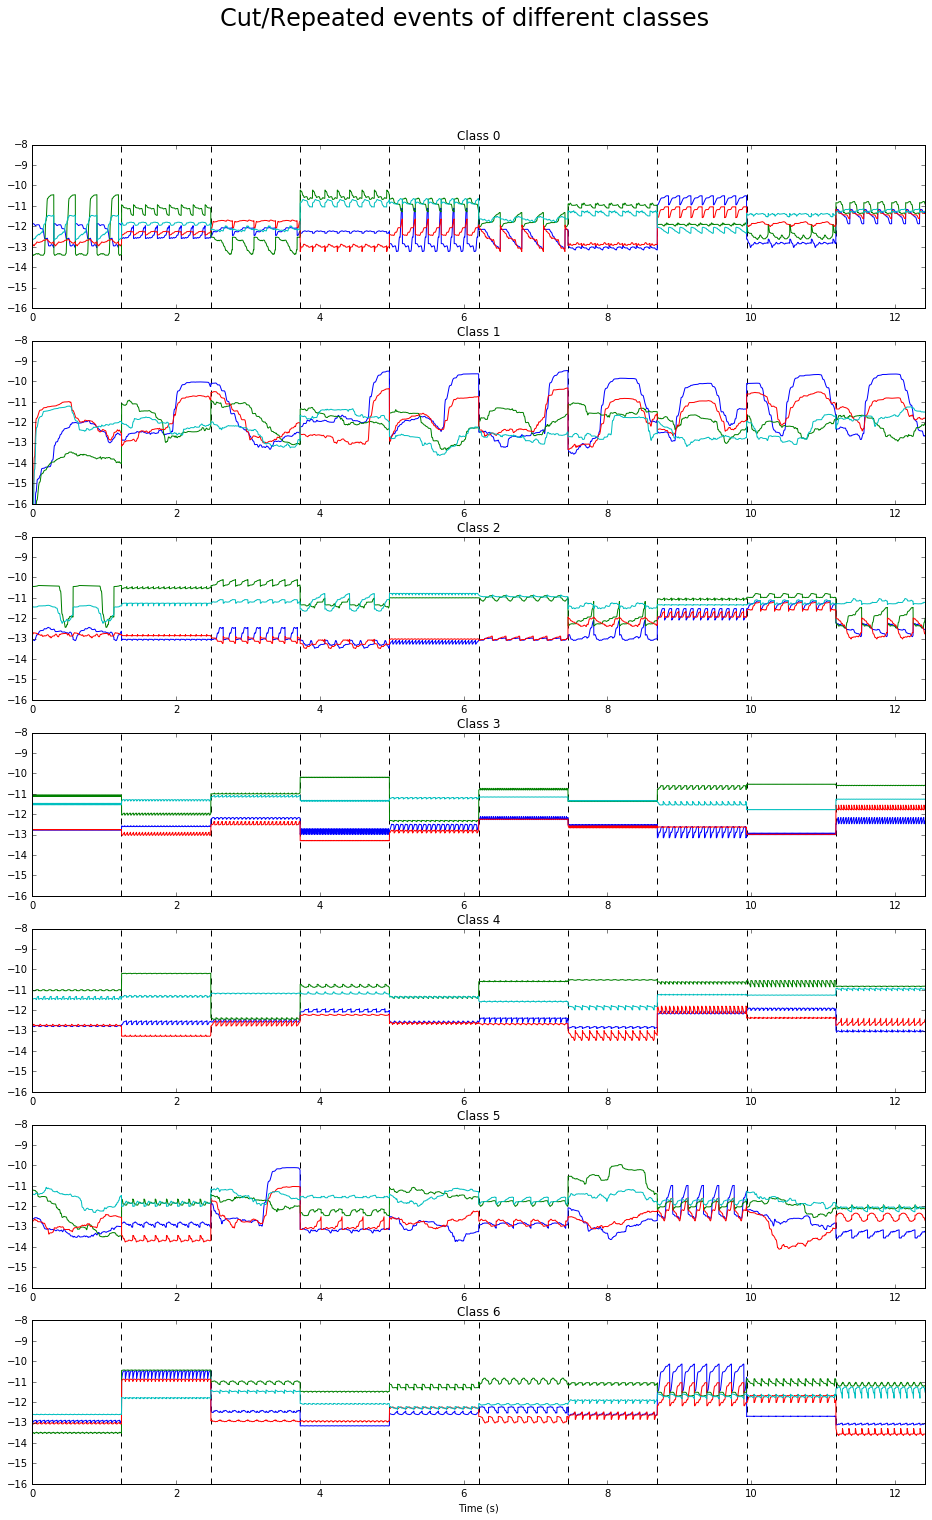

In [15]:
%matplotlib inline
#################### Plot events which have been cut or repeated to get the same length ########################################
f, axarr = plot_feat(w_feattr[0])
f.suptitle('Cut/Repeated events of different classes', fontsize = 24)
plt.show()

To resize our events we can use different schemes, I have called this one the "Cut/Repeat technic". It resizes the events to the average length using the following algorithm :

If the event length is longer than the average length, then it is truncated.
If the event length is shorter than the average length, then the event is concatenated to itself until having the right length.

We can see that class 1 which has longer length than other classes is troncated whereas class 0,2,3,4,6 are repeated. For the class 5, it depends.

In [11]:
########################################### Resample data in order to get the same length for each event ########################
for k in subjects:
    feattr = feattr_all[k-1]
    labels = labels_all[k-1]
    feattr, labels = resample_data(feattr, labels, 0)
    np.savez('resampled/resampled_subject_' + str(k), feattr, labels)

In [13]:
################################# Get back resampled data ####################################################################
r_feattr_all = []
r_labels_all = []

for k in subjects:
    filename = 'resampled/resampled_subject_' + str(k) + '.npz'
    datas = np.load(filename)
    feattr = datas['arr_0']
    labels = datas['arr_1']
    r_feattr_all.append(feattr)
    r_labels_all.append(labels)

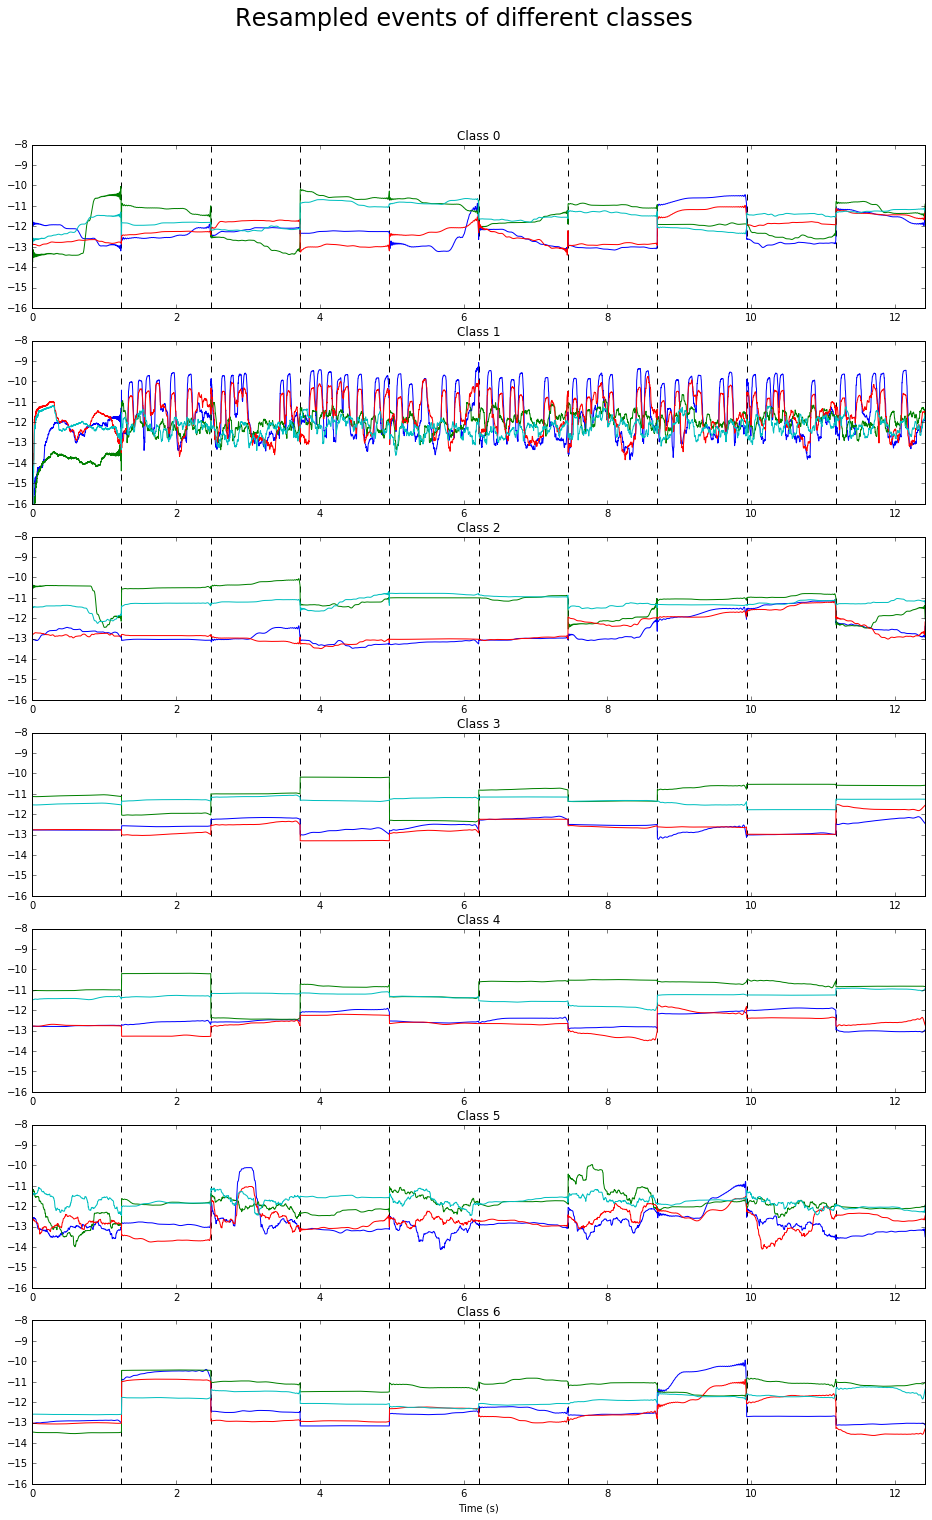

In [54]:
%matplotlib inline
######################################## Plot resampled data ####################################################################
f, axarr = plot_feat(r_feattr_all[0])
f.suptitle('Resampled events of different classes', fontsize=24)
plt.show()

An other way to resize the events to the average length is to resample them. For the signals above, a rectangular window have been used.

ROC Curves
--------------------------------------------------------------------------------------------------------------------------------

All the following ROC curves have been obtained using a One versus All scheme. It means that one classifier have been trained for each class n (except class 0). For this classifier there are only 2 classes : Class n and Class not n.
8 curves are plotted for each subject : 
 - 6 curves corresponding to ROC curves of the 6 classes
 - the micro-average which is the ROC curve if we consider all the classes as only one class
 - the macro-average which is the mean of the ROC curves of the 6 classes

The first classifier used is the Linear Discriminant Analysis (LDA) which separate datas using an hyperplan. It assumes that the 2 classes have a normal distribution and the same covariance.

C:\Users\Martin\Miniconda2\envs\myenv\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


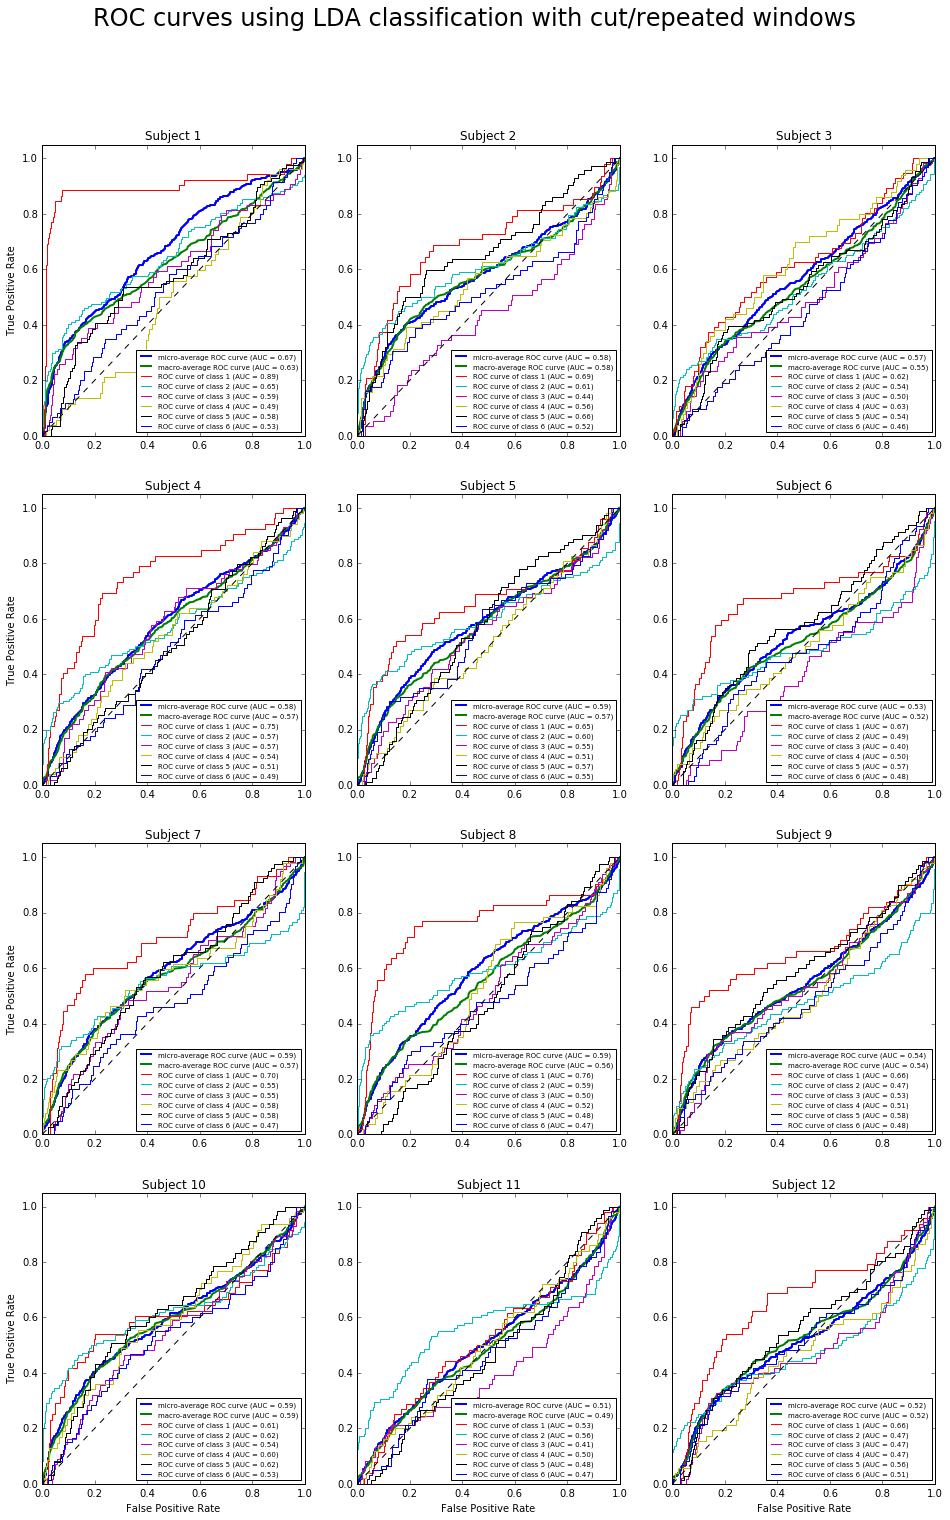

In [17]:
%matplotlib inline
##############################################  LDA cut/repeated  ###############################################################
n_classes = 6
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using LDA classification with cut/repeated windows',fontsize = 24) 

for k in range (len(subjects)):
    feattr, labels = mix_all(w_feattr_all[k], w_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

Except for subject 1 class 1, the performances are not good, it could be explicated by the fact that the classes have not the same covariance.

C:\Users\Martin\Miniconda2\envs\myenv\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


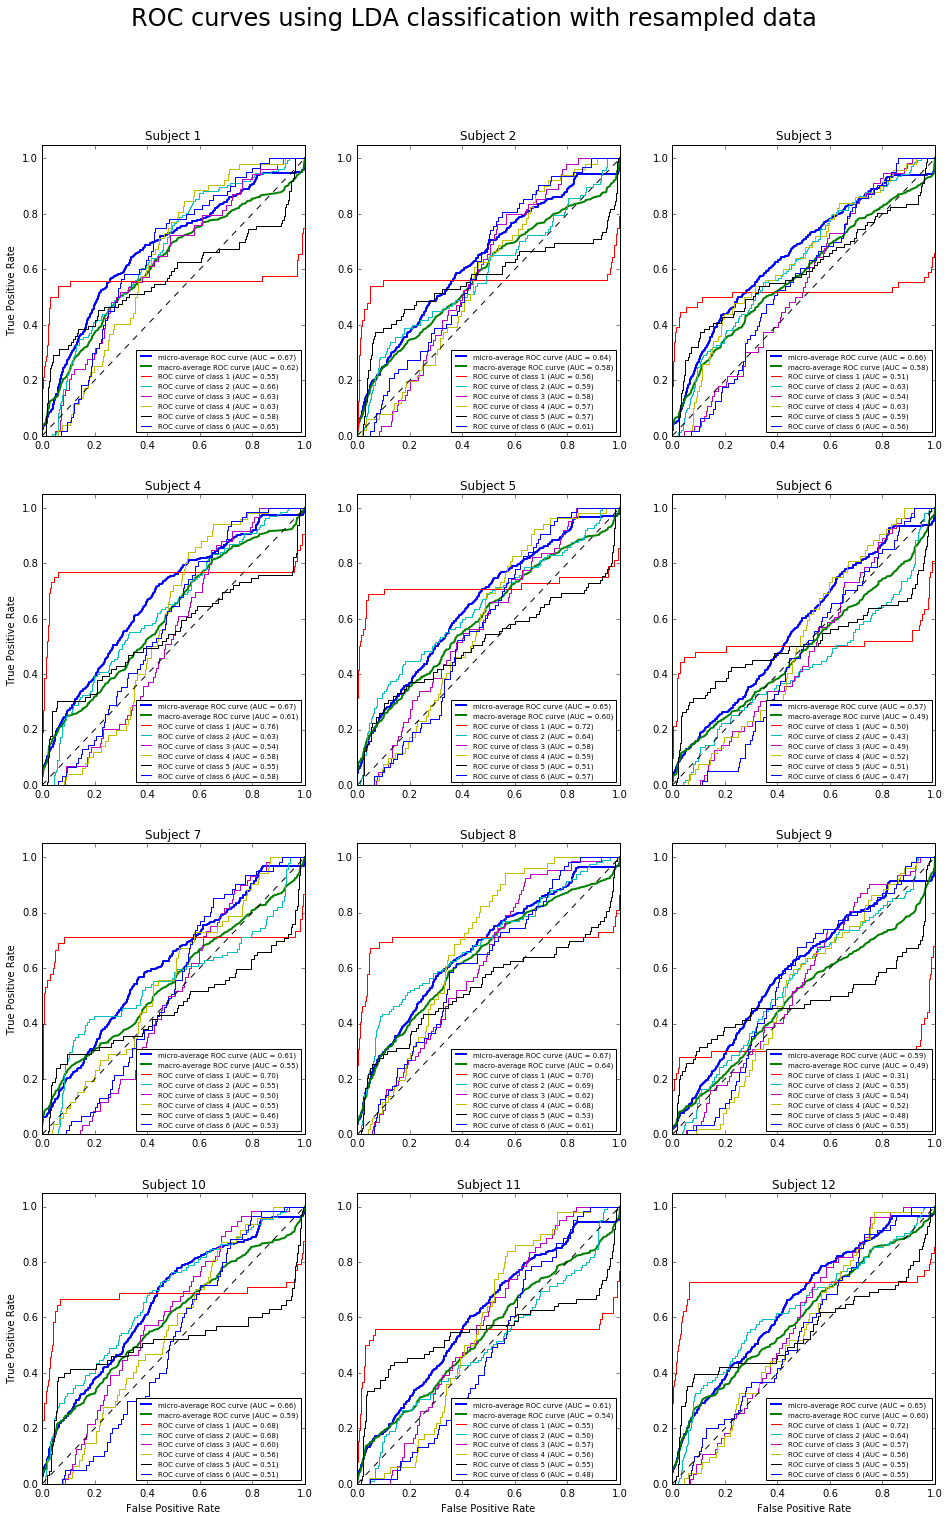

In [55]:
%matplotlib inline
##############################################  LDA resampled  ##################################################################
n_classes = 6
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using LDA classification with resampled data',fontsize = 24) 

for k in range (len(subjects)):
    #Prepare train/test data
    feattr, labels = mix_all(r_feattr_all[k], r_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

With resampled data, with low FPR, the performance is quite good but then there is a plateau. I don't know how to explain this yet. 
--------------------------------------------------------------------------------------------------------------------------------


The second classifier used is the Quadratic Discriminant Analysis. It's derivated from LDA but does not assume the equality of the covariances.

C:\Users\Martin\Miniconda2\envs\myenv\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


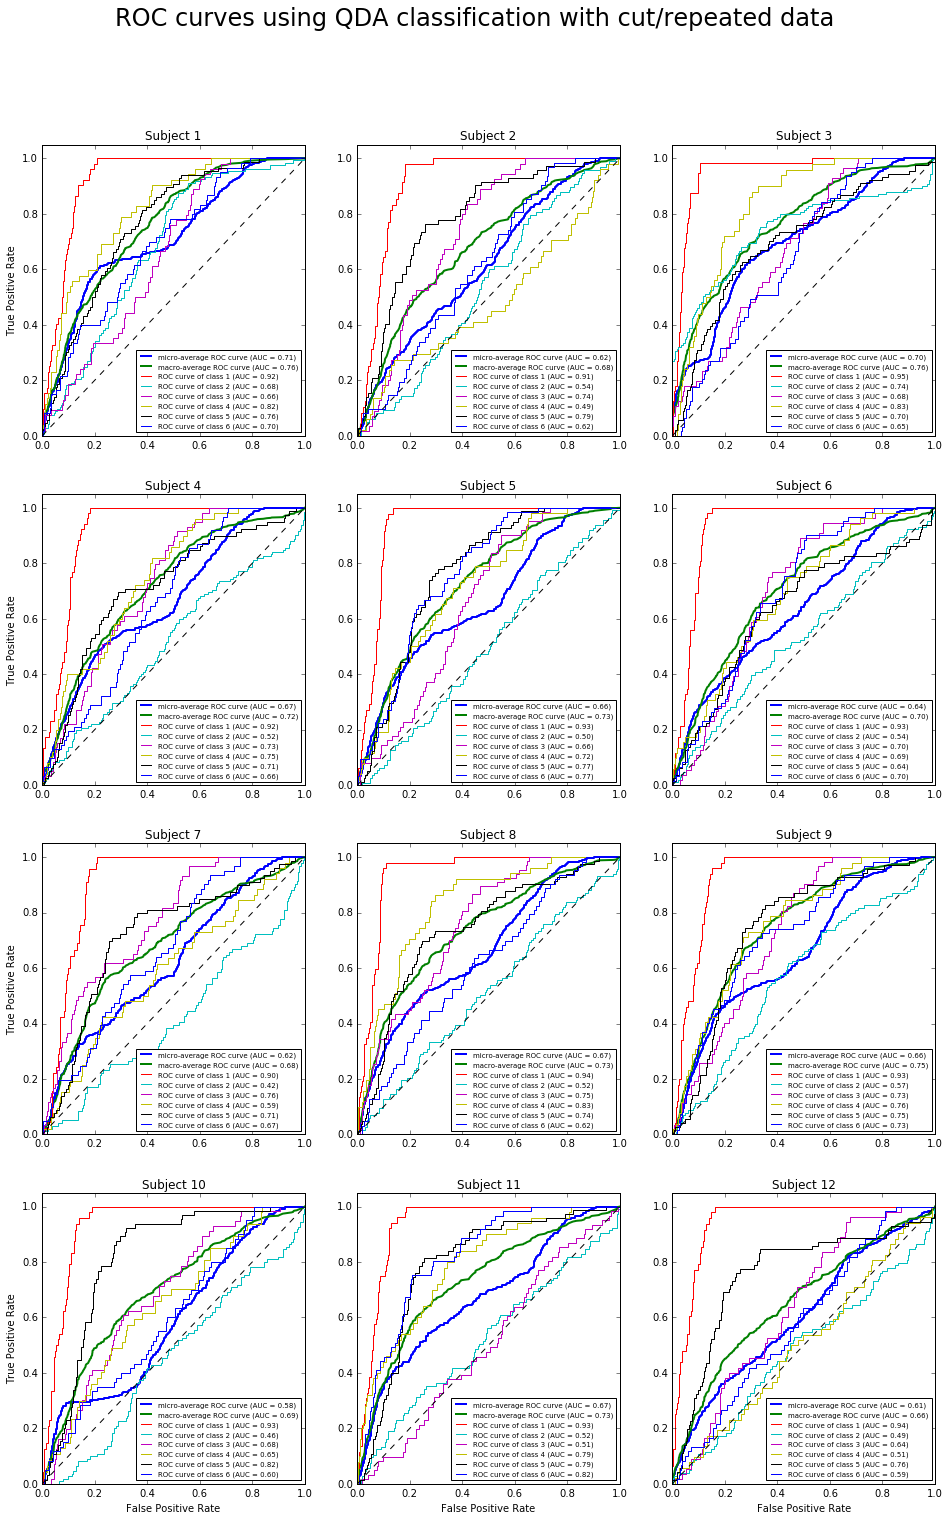

In [14]:
%matplotlib inline
##############################################  QDA cut/repeat  #################################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using QDA classification with cut/repeated data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(w_feattr_all[k], w_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(QuadraticDiscriminantAnalysis())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

For cut/repeated data, the performance for class 1 is very good

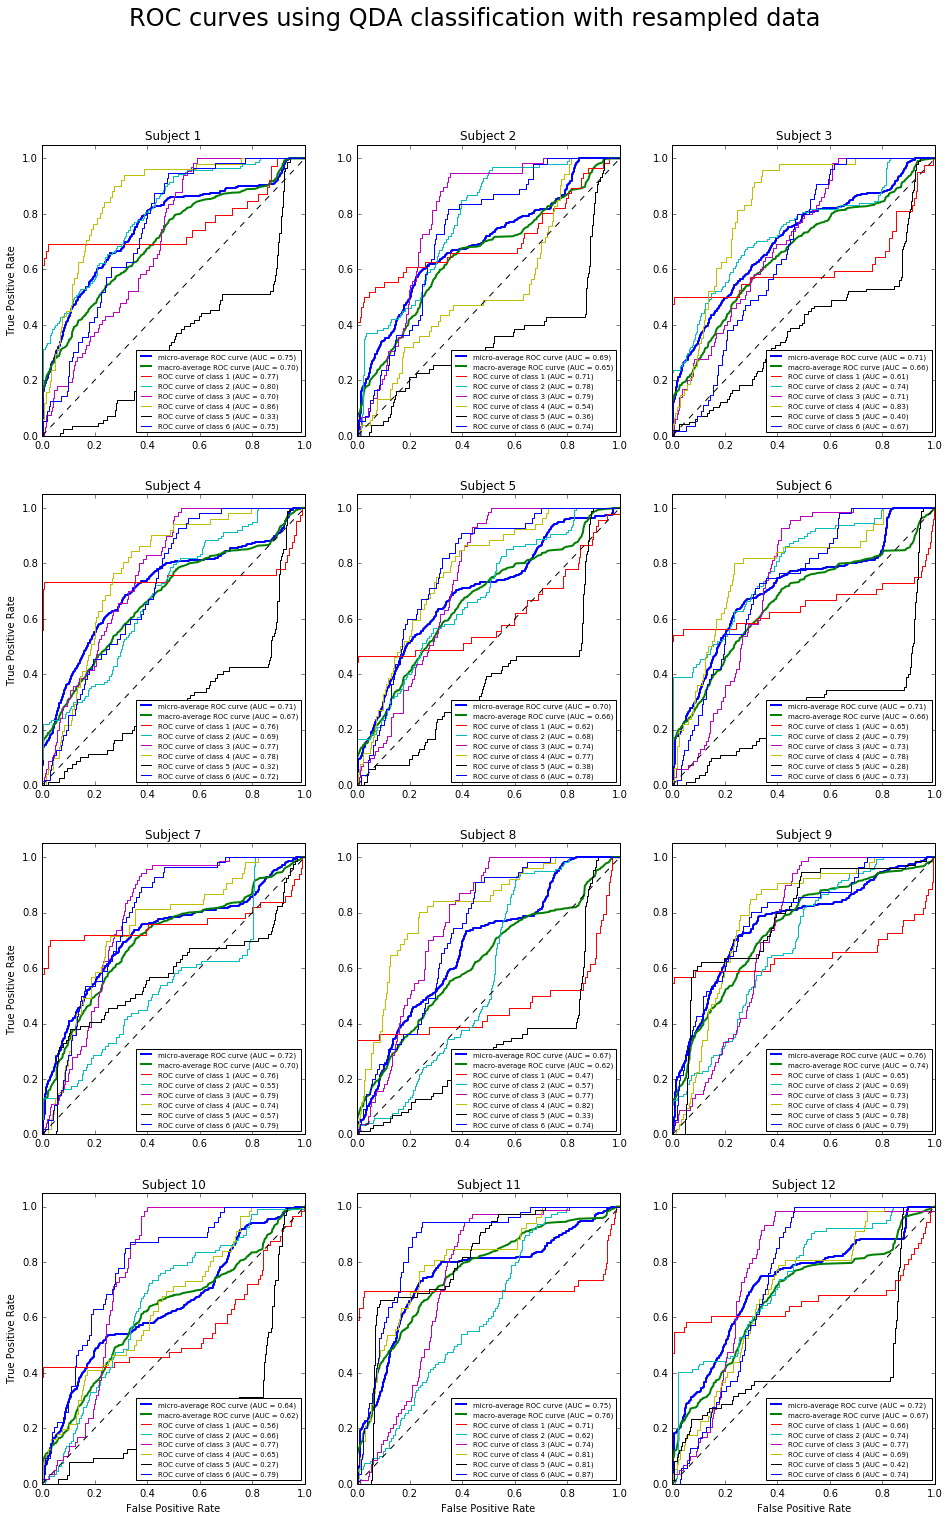

In [16]:
%matplotlib inline
##############################################  QDA resampled  #############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using QDA classification with resampled data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(r_feattr_all[k], r_labels_all[k], 3)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(QuadraticDiscriminantAnalysis())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

For the resampled data, the performance is worse for class 1, we have the same plateau effect than for resampled data in LDA. For some subjects, for some classes like class 3, 5 or 6, the performance is not that bad.
--------------------------------------------------------------------------------------------------------------------------------


The following classifier is called Support Vector Machine. The idea is to define a hyperplan whose the margin between the samples from each class and the hyperplan is maximum.

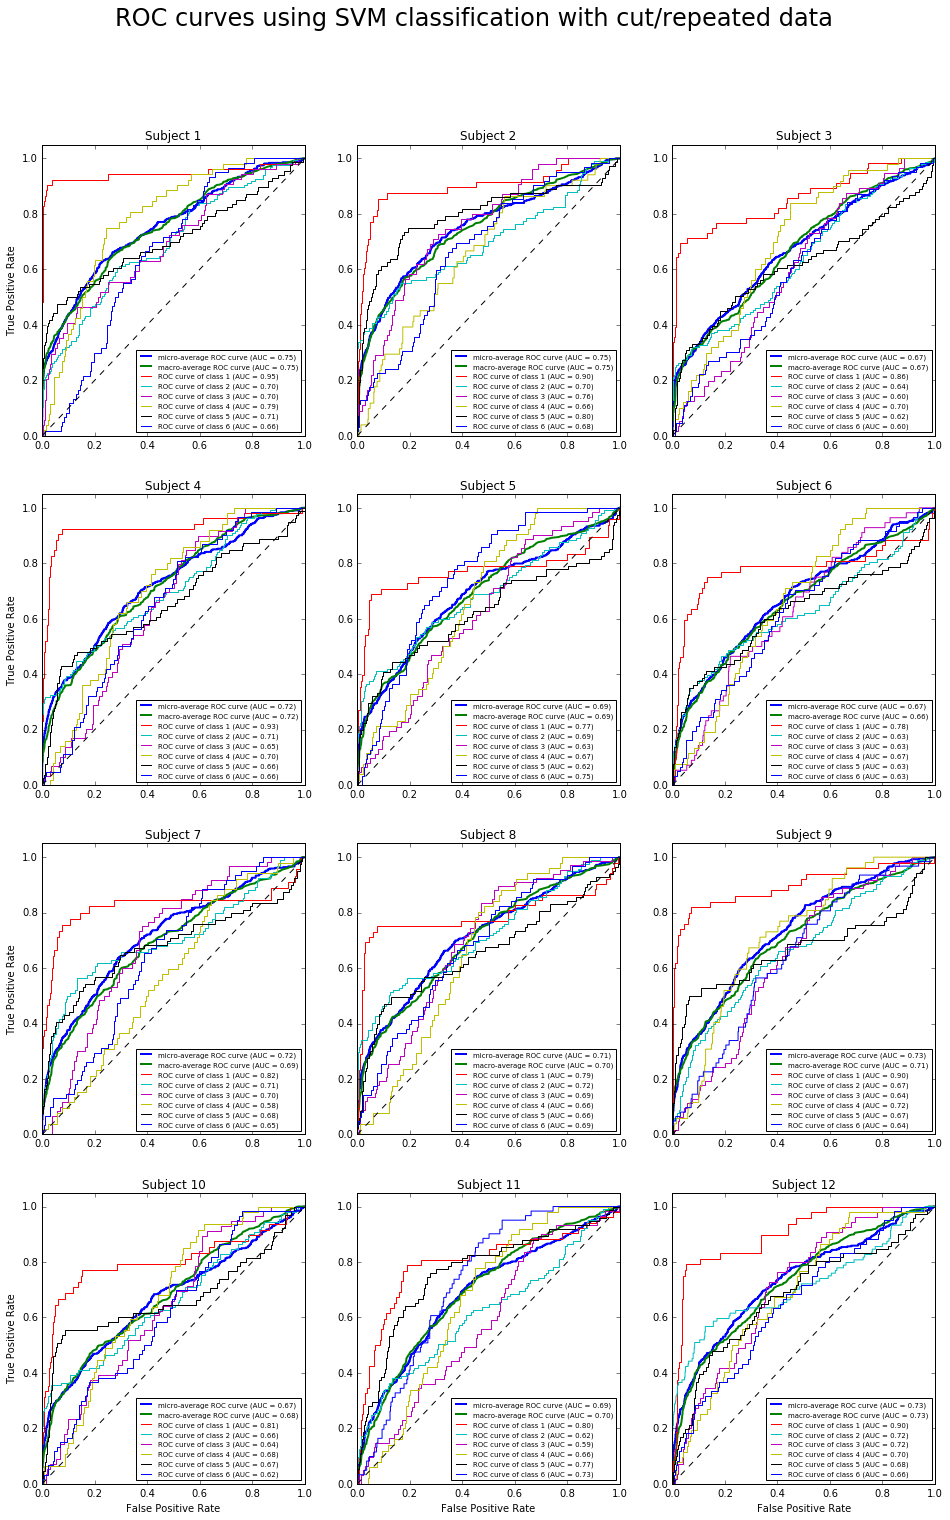

In [17]:
%matplotlib inline
##############################################  SVM cut/repeated  ###############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using SVM classification with cut/repeated data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(w_feattr_all[k], w_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(svm.SVC())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

For cut/repeated data, the performance for class 1 is variable, but not excellent.

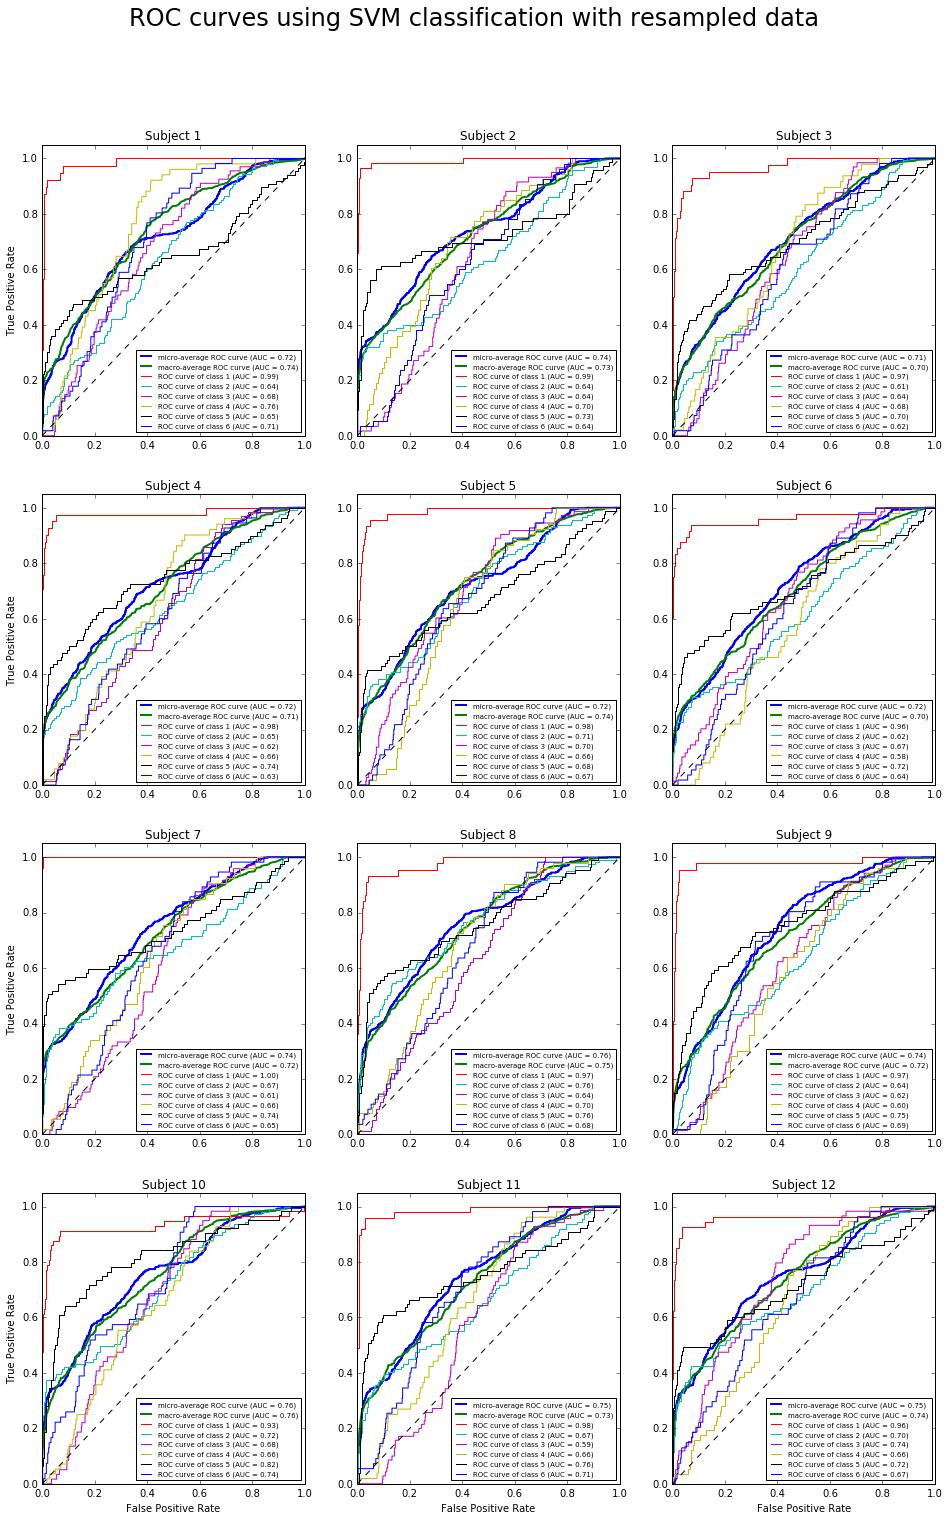

In [18]:
%matplotlib inline
##############################################  SVM resampled  #############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using SVM classification with resampled data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(r_feattr_all[k], r_labels_all[k], 3)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(svm.SVC())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

This time, with resampled data, the performance for class 1 is almost perfect.
--------------------------------------------------------------------------------------------------------------------------------


The last classifier is the logistic regression, it is a classifier using the logistic function.

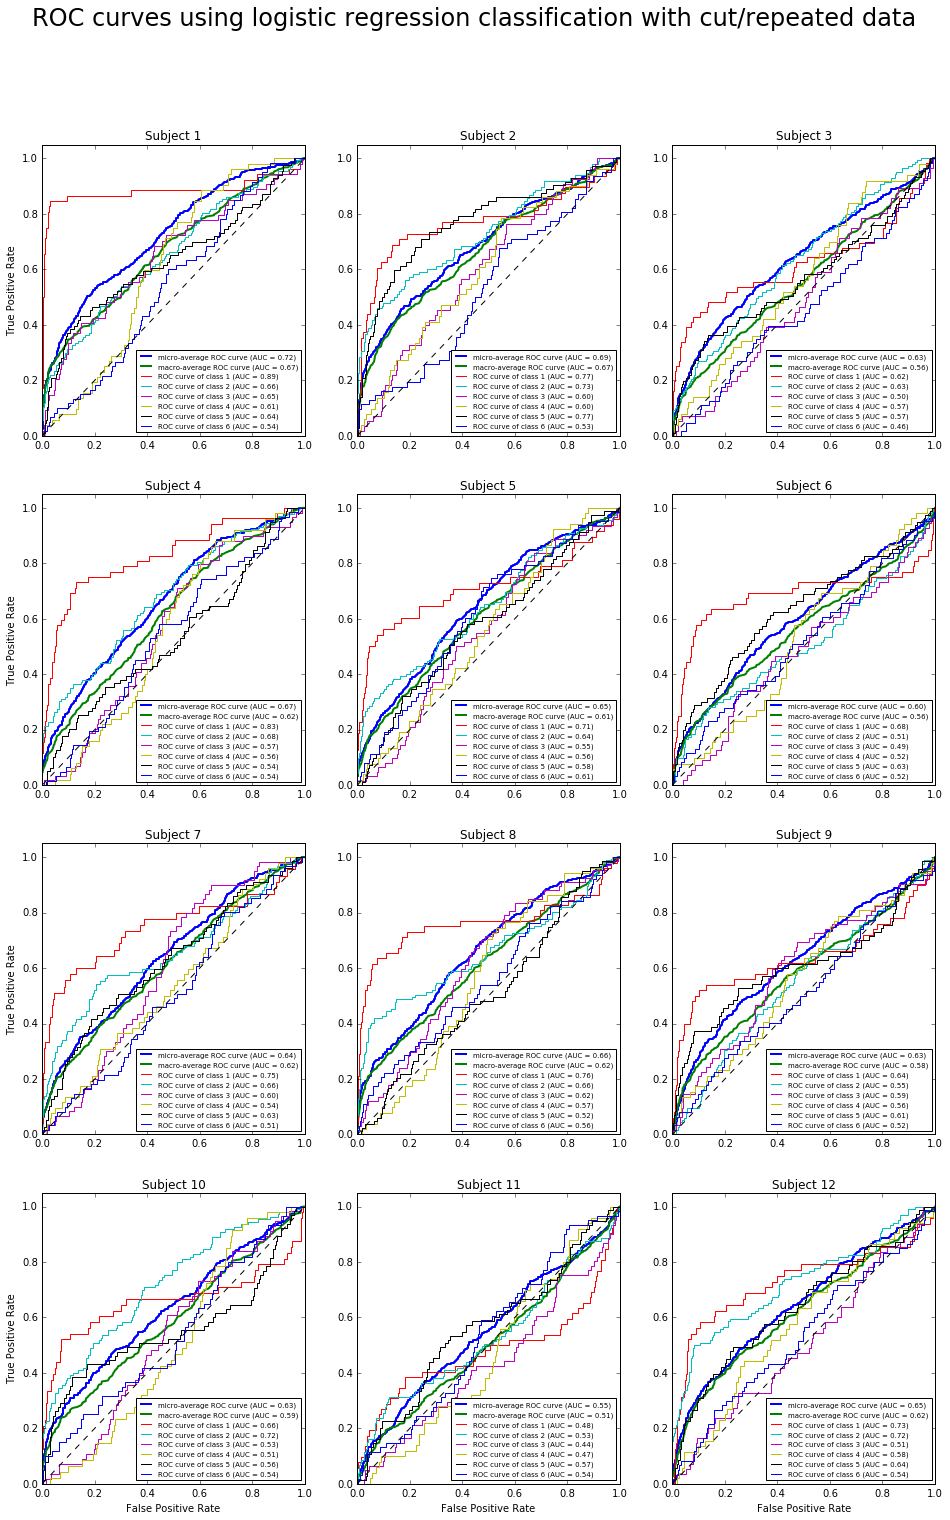

In [61]:
%matplotlib inline
##############################################  Log reg cut/repeat  #############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using logistic regression classification with cut/repeated data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(w_feattr_all[k], w_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(LogisticRegression())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

For cut/repeated data, the performance are not good, even for class 1 (except for subject 1)

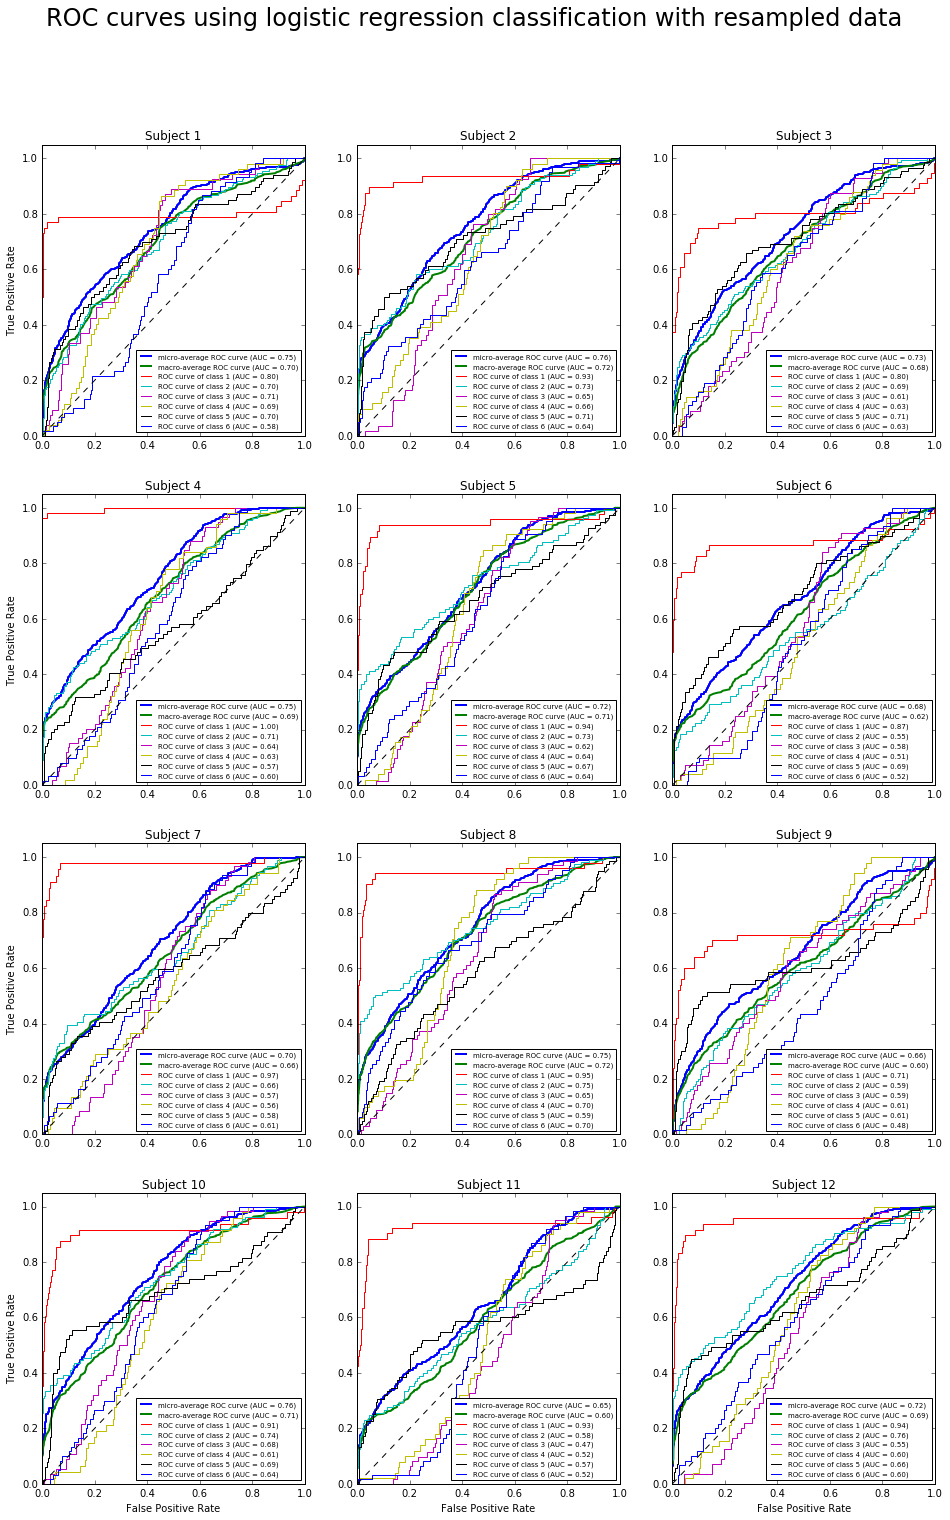

In [60]:
%matplotlib inline
##############################################  Log reg  resampled  #############################################################
f, axarr = prepare_subplot(4,3,24,16)
f.suptitle('ROC curves using logistic regression classification with resampled data',fontsize = 24)
for k in range (len(subjects)):
    feattr, labels = mix_all(r_feattr_all[k], r_labels_all[k], 11)
    cut_point = 8*len(feattr)//10
    
    X_train = feattr[:cut_point,:,0]
    X_test = feattr[cut_point:,:,0]
    y_train = np.array(labels[:cut_point])
    y_test = np.array(labels[cut_point:])
    #Learn to predict each class against the other
    classifier = OneVsRestClassifier(LogisticRegression())
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    #Plot ROC curves
    roc_function(y_score, y_test, k, axarr)
plt.show()

With resampled data, the performance are quite good for class 1, except for subject 9.